In [56]:
#IMPORT
import os
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [57]:
# Càrrega dels fitxers.
filename = [r'BCN_Operations_2019-12-09.csv', r'BCN_Operations_2019-12-10.csv', r'BCN_Operations_2019-12-11.csv',
           r'BCN_Operations_2019-12-12.csv', r'BCN_Operations_2019-12-13.csv', r'BCN_Operations_2019-12-14.csv',
           r'BCN_Operations_2019-12-15.csv']
# Llista buida on guardarem el número de files de cda arxiu.
len_df = []

# Carreguem tots els arxius.
for i in range(0,len(filename)):
    df_day = pd.read_csv(filename[i], sep=',', header=0, engine='python')
    len_df.append(len(df_day))
    if (i==0):
        df_week = df_day
    else:
        df_week = pd.concat([df_week,df_day])

In [58]:
# Variació del número de files de l'arxiu.
for i in range(0,len(filename)):
    print('Nom arxiu: %s\tNúm files: %d' % (filename[i], len_df[i]))

Nom arxiu: BCN_Operations_2019-12-09.csv	Núm files: 2267
Nom arxiu: BCN_Operations_2019-12-10.csv	Núm files: 1774
Nom arxiu: BCN_Operations_2019-12-11.csv	Núm files: 1788
Nom arxiu: BCN_Operations_2019-12-12.csv	Núm files: 1937
Nom arxiu: BCN_Operations_2019-12-13.csv	Núm files: 2251
Nom arxiu: BCN_Operations_2019-12-14.csv	Núm files: 1649
Nom arxiu: BCN_Operations_2019-12-15.csv	Núm files: 2129


In [59]:
# Exploració de les dades.
df_week.head(5)

,Unnamed: 0,Scheduled Date,City,IATA,Airline,Flight,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate
0,0,2019-12-09,Buenos Aires,(EZE),Iberia,IB2601,Departure,01:30,1.0,Landed - On-time,2019-12-09,01:23,D16
1,1,2019-12-09,Palma Mallorca,(PMI),Swiftair,WT112,Departure,04:30,NaN,En Route,2019-12-09,04:30,-
2,2,2019-12-09,Algiers,(ALG),Vueling,VY7476,Departure,06:00,1.0,Landed - On-time,2019-12-09,05:52,E73
3,3,2019-12-09,Algiers,(ALG),Iberia,IB5682,Departure,06:00,1.0,Landed - On-time,2019-12-09,05:52,E73
4,4,2019-12-09,Amsterdam,(AMS),KLM,KL1662,Departure,06:00,1.0,Landed - On-time,2019-12-09,06:04,B32


In [60]:
# Exploració de les dades.
df_week.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13795 entries, 0 to 2128
Data columns (total 13 columns):
Unnamed: 0        13795 non-null int64
Scheduled Date    13795 non-null object
City              13795 non-null object
IATA              13795 non-null object
Airline           13795 non-null object
Flight            13795 non-null object
Operation         13795 non-null object
Scheduled Time    13795 non-null object
Terminal          13728 non-null float64
Status            13795 non-null object
Real Date         13795 non-null object
Real Time         13795 non-null object
Gate              13795 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 1.5+ MB


In [61]:
# Creació d'un arxiu exclusiu amb les dades de Vueling.
df_vueling = df_week[df_week.Airline=='Vueling ']
len(df_vueling)

2002

In [62]:
# Codi compartit - eliminació duplicats.
columnes_drop = ['Unnamed: 0', 'Airline', 'Flight']
df_week_ = df_week.drop(columnes_drop, axis=1)
df_week_ = pd.DataFrame.drop_duplicates(df_week_, keep='first').reset_index(drop=True)
df_week_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5328 entries, 0 to 5327
Data columns (total 10 columns):
Scheduled Date    5328 non-null object
City              5328 non-null object
IATA              5328 non-null object
Operation         5328 non-null object
Scheduled Time    5328 non-null object
Terminal          5273 non-null float64
Status            5328 non-null object
Real Date         5328 non-null object
Real Time         5328 non-null object
Gate              5328 non-null object
dtypes: float64(1), object(9)
memory usage: 416.4+ KB


In [63]:
# Càlcul delay - Diferència entre schedule i real.
# llista on guardar el delay.
delay = []
for i in range(0,len(df_week_)):
    # obtenció del dia i hora de l'operació.
    sch_date_i = df_week_.iloc[i, df_week_.columns.get_loc("Scheduled Date")]
    sch_time_i = df_week_.iloc[i, df_week_.columns.get_loc("Scheduled Time")]
    real_date_i = df_week_.iloc[i, df_week_.columns.get_loc("Real Date")]
    real_time_i = df_week_.iloc[i, df_week_.columns.get_loc("Real Time")]
    #timestamp de l'hora.
    sch_i = datetime.timestamp(datetime.strptime(sch_date_i + ' ' + sch_time_i, '%Y-%m-%d %H:%M'))
    real_i = datetime.timestamp(datetime.strptime(real_date_i + ' ' + real_time_i, '%Y-%m-%d %H:%M'))
    
    if (sch_i==real_i):
        delay.append(0)
    else:
        delay.append(-((sch_i-real_i)/60))

# adjuntem els valors de delay al dataframe.
df_week_['Delay'] = delay
df_week_.head()

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay
0,2019-12-09,Buenos Aires,(EZE),Departure,01:30,1.0,Landed - On-time,2019-12-09,01:23,D16,-7.0
1,2019-12-09,Palma Mallorca,(PMI),Departure,04:30,NaN,En Route,2019-12-09,04:30,-,0.0
2,2019-12-09,Algiers,(ALG),Departure,06:00,1.0,Landed - On-time,2019-12-09,05:52,E73,-8.0
3,2019-12-09,Amsterdam,(AMS),Departure,06:00,1.0,Landed - On-time,2019-12-09,06:04,B32,4.0
4,2019-12-09,Frankfurt,(FRA),Departure,06:00,1.0,Landed - On-time,2019-12-09,05:58,C72,-2.0


In [64]:
# Exploració de les dades.
df_week_.Delay.describe()

count    5328.000000
mean        8.073386
std        53.655116
min      -185.000000
25%        -6.000000
50%         0.000000
75%        11.000000
max      1410.000000
Name: Delay, dtype: float64

In [65]:
# Divisió en blocs horaris segons l'schedule
# llista on guardar el bloc horari.
bloc = []
for i in range(0,len(df_week_)):
    bloc.append(int((df_week_.iloc[i, df_week_.columns.get_loc("Scheduled Time")])[0:2]))

# adjuntem els valors del bloc horari al dataframe.
df_week_['Time block'] = bloc
df_week_.head()

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block
0,2019-12-09,Buenos Aires,(EZE),Departure,01:30,1.0,Landed - On-time,2019-12-09,01:23,D16,-7.0,1
1,2019-12-09,Palma Mallorca,(PMI),Departure,04:30,NaN,En Route,2019-12-09,04:30,-,0.0,4
2,2019-12-09,Algiers,(ALG),Departure,06:00,1.0,Landed - On-time,2019-12-09,05:52,E73,-8.0,6
3,2019-12-09,Amsterdam,(AMS),Departure,06:00,1.0,Landed - On-time,2019-12-09,06:04,B32,4.0,6
4,2019-12-09,Frankfurt,(FRA),Departure,06:00,1.0,Landed - On-time,2019-12-09,05:58,C72,-2.0,6


In [66]:
# Creació variable Time
Time = []

# Obtenció dels valors únics com a llista dels dies de la setmana.
time=np.unique(list((df_week_['Scheduled Date'])))
for i in range(0,len(df_week_)):
    for j in range(0,len(time)):
        if (df_week_.iloc[i, df_week_.columns.get_loc("Scheduled Date")]==time[j]):
            Time.append(df_week_.iloc[i, df_week_.columns.get_loc("Time block")] + j*24)

# adjuntem els valors al dataframe
df_week_['Time'] = Time
df_week_.tail()

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Time
5323,2019-12-15,La Coruna,(LCG),Arrival,23:59,1.0,Landed - Delayed,2019-12-16,00:27,-,28.0,23,167
5324,2019-12-15,London,(LGW),Arrival,23:59,1.0,Landed - Delayed,2019-12-16,00:15,-,16.0,23,167
5325,2019-12-15,Naples,(NAP),Arrival,23:59,1.0,Landed - On-time,2019-12-16,00:01,-,2.0,23,167
5326,2019-12-15,Rennes,(RNS),Arrival,23:59,1.0,Landed - On-time,2019-12-15,23:56,-,-3.0,23,167
5327,2019-12-15,Venice,(VCE),Arrival,23:59,2.0,Landed - Delayed,2019-12-16,00:14,-,15.0,23,167


In [67]:
# Valors NaN
df_week_[pd.isnull(df_week_.Terminal)].head(10)

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Time
1,2019-12-09,Palma Mallorca,(PMI),Departure,04:30,NaN,En Route,2019-12-09,04:30,-,0.0,4,4
65,2019-12-09,Palma Mallorca,(PMI),Departure,07:45,NaN,Unknown,2019-12-09,07:45,-,0.0,7,7
128,2019-12-09,Bilbao,(BIO),Departure,10:10,NaN,Unknown,2019-12-09,10:10,B25,0.0,10,10
285,2019-12-09,Palma Mallorca,(PMI),Departure,16:10,NaN,Landed - Delayed,2019-12-09,18:05,B41,115.0,16,16
292,2019-12-09,Palma Mallorca,(PMI),Departure,16:30,NaN,Landed - On-time,2019-12-09,16:33,-,3.0,16,16
429,2019-12-09,Marseille,(MRS),Departure,21:50,NaN,Landed,2019-12-09,21:50,-,0.0,21,21
438,2019-12-09,Ibiza,(IBZ),Departure,22:55,NaN,Unknown,2019-12-09,22:55,-,0.0,22,22
458,2019-12-09,Liege,(LGG),Arrival,04:05,NaN,Landed,2019-12-09,04:05,-,0.0,4,4
475,2019-12-09,Barcelona,(BCN),Arrival,08:15,NaN,Diverted,2019-12-09,09:13,-,58.0,8,8
665,2019-12-09,London,(LGW),Arrival,14:45,NaN,Diverted,2019-12-09,17:26,-,161.0,14,14


In [68]:
# Eliminació dels valors absents
index_nan = list(df_week_[pd.isnull(df_week_.Terminal)].index)
df_week_ = df_week_.drop(index=index_nan).reset_index(drop=True)
df_week_[pd.isnull(df_week_.Terminal)]

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Time


In [69]:
# Canvi Terminal float to string
for i in range(0, len(df_week_)):
    df_week_.iloc[i,df_week_.columns.get_loc("Terminal")] = \
    str(df_week_.iloc[i,df_week_.columns.get_loc("Terminal")])[0]
df_week_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5273 entries, 0 to 5272
Data columns (total 13 columns):
Scheduled Date    5273 non-null object
City              5273 non-null object
IATA              5273 non-null object
Operation         5273 non-null object
Scheduled Time    5273 non-null object
Terminal          5273 non-null object
Status            5273 non-null object
Real Date         5273 non-null object
Real Time         5273 non-null object
Gate              5273 non-null object
Delay             5273 non-null float64
Time block        5273 non-null int64
Time              5273 non-null int64
dtypes: float64(1), int64(2), object(10)
memory usage: 535.7+ KB


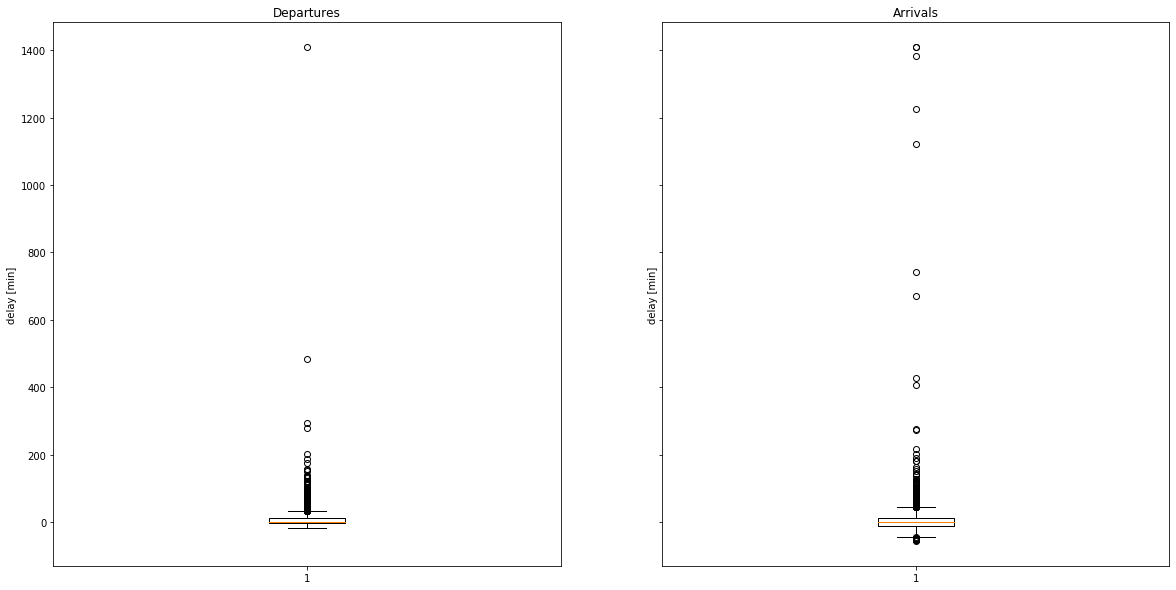

In [70]:
# Valors outliers.
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize=(20,10))
ax1.boxplot(x = df_week_['Delay'][df_week_.Operation == 'Departure'])
ax1.set(title='Departures', ylabel='delay [min]')
ax2.boxplot(x = df_week_['Delay'][df_week_.Operation == 'Arrival'])
ax2.set(title='Arrivals', ylabel='delay [min]')
plt.show()

In [71]:
# Comptem per Status.
Counter(df_week_.Status)

Counter({' Landed - On-time': 4067,
         ' Landed': 23,
         ' Landed - Delayed': 1087,
         ' Diverted': 8,
         ' Unknown': 30,
         ' En Route - Delayed': 6,
         ' Canceled': 45,
         ' En Route - On-time': 5,
         ' Scheduled - Delayed': 2})

In [72]:
# Tractament altres valors
df_week_[df_week_.Status == " Unknown"].head(10)

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Time
75,2019-12-09,Timisoara,(TSR),Departure,08:00,2,Unknown,2019-12-09,08:00,W46,0.0,8,8
95,2019-12-09,Algiers,(ALG),Departure,09:20,1,Unknown,2019-12-09,09:28,D11,8.0,9,9
103,2019-12-09,Debrecen,(DEB),Departure,09:35,2,Unknown,2019-12-09,09:42,S25,7.0,9,9
312,2019-12-09,Cluj-Napoca,(CLJ),Departure,17:35,2,Unknown,2019-12-09,17:41,Y58,6.0,17,17
331,2019-12-09,Istanbul,(ISL),Departure,18:10,1,Unknown,2019-12-09,18:25,D4,15.0,18,18
332,2019-12-09,Kutaisi,(KUT),Departure,18:10,2,Unknown,2019-12-09,18:26,W46,16.0,18,18
410,2019-12-09,Skopje,(SKP),Departure,21:15,2,Unknown,2019-12-09,21:17,W46,2.0,21,21
1175,2019-12-10,Katowice,(KTW),Departure,20:40,2,Unknown,2019-12-10,20:42,U36,2.0,20,44
1184,2019-12-10,Casablanca,(CMN),Departure,21:20,2,Unknown,2019-12-10,21:29,Y54,9.0,21,45
1622,2019-12-11,Casablanca,(CMN),Departure,10:10,2,Unknown,2019-12-11,10:09,Y55,-1.0,10,58


In [73]:
# Tractament altres valors
df_week_[df_week_.Status == " Canceled"].head(10)

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Time
522,2019-12-09,Bilbao,(BIO),Arrival,10:05,1,Canceled,2019-12-09,10:05,-,0.0,10,10
850,2019-12-09,Ibiza,(IBZ),Arrival,23:05,1,Canceled,2019-12-09,23:05,-,0.0,23,23
974,2019-12-10,London,(LHR),Departure,10:10,1,Canceled,2019-12-10,10:10,-,0.0,10,34
1024,2019-12-10,London,(LHR),Departure,12:20,1,Canceled,2019-12-10,12:20,-,0.0,12,36
1049,2019-12-10,London,(LGW),Departure,14:10,2,Canceled,2019-12-10,14:10,-,0.0,14,38
1095,2019-12-10,Milan,(MXP),Departure,16:50,2,Canceled,2019-12-10,16:50,-,0.0,16,40
1124,2019-12-10,Paris,(CDG),Departure,18:10,2,Canceled,2019-12-10,18:10,-,0.0,18,42
1135,2019-12-10,"Basel, Switzerland / Mulhouse",(BSL),Departure,18:45,2,Canceled,2019-12-10,18:45,-,0.0,18,42
1142,2019-12-10,Lyon,(LYS),Departure,19:00,2,Canceled,2019-12-10,19:00,-,0.0,19,43
1148,2019-12-10,Paris,(ORY),Departure,19:20,1,Canceled,2019-12-10,19:20,-,0.0,19,43


In [74]:
# Tractament altres valors
df_week_[df_week_.Status == " Diverted"].head(10)

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Time
31,2019-12-09,Bilbao,(BIO),Departure,07:00,1,Diverted,2019-12-09,07:03,A1,3.0,7,7
237,2019-12-09,Palma Mallorca,(PMI),Departure,14:15,1,Diverted,2019-12-09,14:14,B43,-1.0,14,14
392,2019-12-09,Ibiza,(IBZ),Departure,20:30,1,Diverted,2019-12-09,20:38,B47,8.0,20,20
1867,2019-12-11,Buenos Aires,(EZE),Arrival,05:30,1,Diverted,2019-12-11,05:30,-,0.0,5,53
2029,2019-12-11,London,(LTN),Arrival,15:35,2,Diverted,2019-12-11,16:53,-,78.0,15,63
2964,2019-12-13,Vigo,(VGO),Departure,07:20,1,Diverted,2019-12-13,07:23,B51,3.0,7,103
3052,2019-12-13,Newark,(EWR),Departure,11:00,1,Diverted,2019-12-13,11:12,D8,12.0,11,107
3900,2019-12-14,Bristol,(BRS),Departure,10:55,2,Diverted,2019-12-14,10:50,M6,-5.0,10,130


In [75]:
# Tractament altres valors
df_week_[df_week_.Status == " En Route - On-time"]

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Time
1195,2019-12-10,Vilnius,(VNO),Departure,21:50,2,En Route - On-time,2019-12-10,21:48,U31,-2.0,21,45
3231,2019-12-13,Cluj-Napoca,(CLJ),Departure,17:35,2,En Route - On-time,2019-12-13,17:38,Y58,3.0,17,113
3252,2019-12-13,Kutaisi,(KUT),Departure,18:10,2,En Route - On-time,2019-12-13,18:20,Y55,10.0,18,114
4061,2019-12-14,Algiers,(ALG),Departure,19:05,1,En Route - On-time,2019-12-14,18:55,D21,-10.0,19,139
4104,2019-12-14,Nador,(NDR),Departure,22:10,2,En Route - On-time,2019-12-14,22:08,Y57,-2.0,22,142


In [76]:
len(df_week_[df_week_.Status == " Canceled"])

45

In [77]:
# Eliminació de les observacions amb Status Canceled
index_can = list(df_week_[df_week_.Status == " Canceled"].index)
df_week_ = df_week_.drop(index=index_can).reset_index(drop=True)
df_week_[df_week_.Status == " Canceled"]

,Scheduled Date,City,IATA,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Time


In [78]:
# Cas Vueling.
# Transformacions de dades - columnes delay, bloc i dia setmana.
delay = []
bloc = []
day = []
for i in range(0,len(df_vueling)):
    # obtenció del dia i hora de l'operació.
    sch_date_i = df_vueling.iloc[i, df_vueling.columns.get_loc("Scheduled Date")]
    sch_time_i = df_vueling.iloc[i, df_vueling.columns.get_loc("Scheduled Time")]
    real_date_i = df_vueling.iloc[i, df_vueling.columns.get_loc("Real Date")]
    real_time_i = df_vueling.iloc[i, df_vueling.columns.get_loc("Real Time")]
    #timestamp de l'hora.
    sch_i = datetime.timestamp(datetime.strptime(sch_date_i + ' ' + sch_time_i, '%Y-%m-%d %H:%M'))
    real_i = datetime.timestamp(datetime.strptime(real_date_i + ' ' + real_time_i, '%Y-%m-%d %H:%M'))
    day.append(datetime.strptime(sch_date_i, '%Y-%m-%d').strftime("%u"))
    # bloc horari
    bloc.append(int((df_vueling.iloc[i, df_vueling.columns.get_loc("Scheduled Time")])[0:2]))
    if (sch_i==real_i):
        delay.append(0)
    else:
        delay.append(-((sch_i-real_i)/60))

# adjuntem els valors de delay al dataframe.
df_vueling['Delay'] = delay
df_vueling['Time block'] = bloc
df_vueling['Day'] = day

# Eliminem els nan
index_nan = list(df_vueling[pd.isnull(df_vueling.Terminal)].index)
df_vueling = df_vueling.drop(index=index_nan).reset_index(drop=True)
df_vueling[pd.isnull(df_vueling.Terminal)]

df_vueling.tail()

C:\Users\Xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Xavier\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

,Unnamed: 0,Scheduled Date,City,IATA,Airline,Flight,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Day
1981,2112,2019-12-15,Amsterdam,(AMS),Vueling,VY8305,Arrival,23:59,1.0,Landed - Delayed,2019-12-16,00:18,-,19.0,23,7
1982,2116,2019-12-15,La Coruna,(LCG),Vueling,VY1291,Arrival,23:59,1.0,Landed - Delayed,2019-12-16,00:27,-,28.0,23,7
1983,2119,2019-12-15,London,(LGW),Vueling,VY7821,Arrival,23:59,1.0,Landed - Delayed,2019-12-16,00:15,-,16.0,23,7
1984,2122,2019-12-15,Naples,(NAP),Vueling,VY6503,Arrival,23:59,1.0,Landed - On-time,2019-12-16,00:01,-,2.0,23,7
1985,2126,2019-12-15,Rennes,(RNS),Vueling,VY1525,Arrival,23:59,1.0,Landed - On-time,2019-12-15,23:56,-,-3.0,23,7


In [79]:
# Eliminació dels valors absents
index_nan = list(df_vueling[pd.isnull(df_vueling.Terminal)].index)
df_vueling = df_vueling.drop(index=index_nan).reset_index(drop=True)
df_vueling[pd.isnull(df_vueling.Terminal)]

,Unnamed: 0,Scheduled Date,City,IATA,Airline,Flight,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Day


In [80]:
# Eliminació de les observacions amb Status Canceled
index_can = list(df_vueling[df_vueling.Status == " Canceled"].index)
df_vueling = df_vueling.drop(index=index_can).reset_index(drop=True)
df_vueling[df_vueling.Status == " Canceled"]

,Unnamed: 0,Scheduled Date,City,IATA,Airline,Flight,Operation,Scheduled Time,Terminal,Status,Real Date,Real Time,Gate,Delay,Time block,Day


In [81]:
df_analisi_1 = pd.DataFrame(data = df_week_[['Time', 'Operation', 'Delay']])
df_analisi_2 = pd.DataFrame(data = df_week_[['Time block', 'Operation', 'Terminal', 'Delay']])
df_analisi_3 = pd.DataFrame(data = df_vueling[['City', 'Operation', 'Time block', 'Delay']])

In [82]:
df_analisi_1.to_csv(r'df_analisi_1.csv', sep=',', header=True, encoding='utf-8')
df_analisi_2.to_csv(r'df_analisi_2.csv', sep=',', header=True, encoding='utf-8')
df_analisi_3.to_csv(r'df_analisi_3.csv', sep=',', header=True, encoding='utf-8')

In [83]:
# Apliquem el groupby al df_analisi_1
df_analisi_1_gb = df_analisi_1.groupby(['Time'])\
                                .agg({'Delay': ('mean', 'count')}).reset_index()
df_analisi_1_gb.columns = ['Time', 'Mean', 'Total op']
df_analisi_1_gb.head()

,Time,Mean,Total op
0,0,97.533333,15
1,1,-17.666667,3
2,5,-24.000000,1
3,6,22.000000,32
4,7,0.369565,46


In [84]:
# Afegim les hores sense operacions.
time_nou = np.arange(0,24*7,1).tolist()
time_nou_df = pd.DataFrame(data=time_nou,columns=['Time'])
df_analisi_1_gb_ = pd.merge(time_nou_df, df_analisi_1_gb, how='outer', on='Time')
df_analisi_1_gb_ = df_analisi_1_gb_.fillna(0)
df_analisi_1_gb_.head()

,Time,Mean,Total op
0,0,97.533333,15.0
1,1,-17.666667,3.0
2,2,0.000000,0.0
3,3,0.000000,0.0
4,4,0.000000,0.0


In [85]:
# Apliquem el groupby al df_analisi_2
df_analisi_2_gb = df_analisi_2.groupby(['Time block', 'Operation', 'Terminal'])\
                                .agg({'Delay': ('sum', 'mean'),
                                 'Time block': 'count'}).reset_index()
df_analisi_2_gb.columns = ['Time block', 'Operation', 'Terminal', 'Sum delay', 'Mean', 'Total op']
df_analisi_2_gb.head()

,Time block,Operation,Terminal,Sum delay,Mean,Total op
0,0,Arrival,1,1440.0,36.923077,39
1,0,Arrival,2,3921.0,392.100000,10
2,1,Arrival,1,556.0,37.066667,15
3,1,Departure,1,-13.0,-1.857143,7
4,2,Arrival,1,-31.0,-31.000000,1


In [86]:
# Guardem les tres transformacions.
df_analisi_1_gb.to_csv(r'df_analisi_1_transf.csv', sep=',', header=True, encoding='utf-8')
df_analisi_2_gb.to_csv(r'df_analisi_2_transf.csv', sep=',', header=True, encoding='utf-8')

In [87]:
# Comprovació de la normalitat de les dades
# Test de Shapiro-Wilk
resultat = stats.shapiro(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='1')])
print("Shapiro-Wilk, Departures T1: %.15f %.2E" % resultat)
resultat = stats.shapiro(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='2')])
print("Shapiro-Wilk, Departures T2: %.15f %.2E" % resultat)
resultat = stats.shapiro(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='1')])
print("Shapiro-Wilk, Arrival T1: %.15f %.2E" % resultat)
resultat = stats.shapiro(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='2')])
print("Shapiro-Wilk, Arrival T2: %.15f %.2E" % resultat)

Shapiro-Wilk, Departures T1: 0.544930458068848 0.00E+00
Shapiro-Wilk, Departures T2: 0.240927159786224 0.00E+00
Shapiro-Wilk, Arrival T1: 0.320438981056213 0.00E+00
Shapiro-Wilk, Arrival T2: 0.220502853393555 0.00E+00


In [88]:
# Eliminem els valors superiors a 60
resultat = stats.shapiro(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<60)])
print("Shapiro-Wilk, Departures T1: %.15f %.2E" % resultat)
resultat = stats.shapiro(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<60)])
print("Shapiro-Wilk, Departures T2: %.15f %.2E" % resultat)
resultat = stats.shapiro(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<60)])
print("Shapiro-Wilk, Arrival T1: %.15f %.2E" % resultat)
resultat = stats.shapiro(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<60)])
print("Shapiro-Wilk, Arrival T2: %.15f %.2E" % resultat)

Shapiro-Wilk, Departures T1: 0.839293301105499 1.52E-38
Shapiro-Wilk, Departures T2: 0.870436728000641 2.61E-25
Shapiro-Wilk, Arrival T1: 0.963418483734131 2.78E-20
Shapiro-Wilk, Arrival T2: 0.936766326427460 5.72E-18


In [89]:
# Comprovació de la normalitat amb valors normalitzats
from sklearn import preprocessing
normalitzat = preprocessing.normalize([np.array(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<60)])])
resultat = stats.shapiro(normalitzat)
print("Shapiro-Wilk, Departures T1: %.15f %.2E" % resultat)
normalitzat = preprocessing.normalize([np.array(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<60)])])
resultat = stats.shapiro(normalitzat)
print("Shapiro-Wilk, Departures T2: %.15f %.2E" % resultat)
normalitzat = preprocessing.normalize([np.array(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<60)])])
resultat = stats.shapiro(normalitzat)
print("Shapiro-Wilk, Arrival T1: %.15f %.2E" % resultat)
normalitzat = preprocessing.normalize([np.array(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<60)])])
resultat = stats.shapiro(normalitzat)
print("Shapiro-Wilk, Arrival T2: %.15f %.2E" % resultat)

Shapiro-Wilk, Departures T1: 0.839293301105499 1.52E-38
Shapiro-Wilk, Departures T2: 0.870436728000641 2.61E-25
Shapiro-Wilk, Arrival T1: 0.963418483734131 2.78E-20
Shapiro-Wilk, Arrival T2: 0.936766326427460 5.72E-18


In [90]:
# Test de Fligner-Killeen comparant terminals quan l'operació és sortida
stats.fligner(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='1')],
            df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='2')])

FlignerResult(statistic=39.39034430916152, pvalue=3.470086377626322e-10)

In [91]:
# Test de Fligner-Killeen comparant terminals quan l'operació és arribada
stats.fligner(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='1')],
            df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='2')])

FlignerResult(statistic=8.160807775135117, pvalue=0.0042805301969872835)

In [92]:
# Test de Fligner-Killeen comparant operacions quan la terminal és la 1
stats.fligner(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='1')],
            df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='1')])

FlignerResult(statistic=156.6036857414893, pvalue=6.248136656660037e-36)

In [93]:
# Test de Fligner-Killeen comparant operacions quan la terminal és la 2
stats.fligner(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='2')],
            df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='2')])

FlignerResult(statistic=33.53588251049654, pvalue=6.996132855837335e-09)

In [94]:
# Test de Fligner-Killeen comparant terminals quan l'operació és sortida eliminant els valors superiors a 60
stats.fligner(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<60)],
            df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<60)])

FlignerResult(statistic=14.915646852710454, pvalue=0.00011242663476618398)

In [95]:
# Test de Fligner-Killeen comparant terminals quan l'operació és arribada eliminant els valors superiors a 60
stats.fligner(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<60)],
            df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<60)])

FlignerResult(statistic=2.6158721901969426, pvalue=0.10579933956279498)

In [96]:
# Test de Fligner-Killeen comparant operacions quan la terminal és la 1 eliminant els valors superiors a 60
stats.fligner(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<60)],
            df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<60)])

FlignerResult(statistic=158.18759954038828, pvalue=2.8161105840774073e-36)

In [97]:
# Test de Fligner-Killeen comparant operacions quan la terminal és la 2 eliminant els valors superiors a 60
stats.fligner(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') 
                                               & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<60)],
            df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') 
                                               & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<60)])

FlignerResult(statistic=43.32008634922436, pvalue=4.6478770033058414e-11)

In [98]:
# ANÀLISI TEMPORAL - Test de Dickey-Fuller
adfuller(df_analisi_1_gb_['Total op'])

(-6.5616650664516065,
 8.351601340445965e-09,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1083.8533558979907)

In [99]:
# CONTRAST D'HIPÒTESI - Test de Mann-Whitney
# Entre Operacions
stats.mannwhitneyu(df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure')], 
             df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival')])

MannwhitneyuResult(statistic=2737461.0, pvalue=7.051422010417602e-36)

In [100]:
# Entre Terminals
stats.mannwhitneyu(df_analisi_2['Delay'][(df_analisi_2['Terminal']=='1')], 
             df_analisi_2['Delay'][(df_analisi_2['Terminal']=='2')])

MannwhitneyuResult(statistic=2824150.5, pvalue=0.0002145726841019686)

In [101]:
# Correlació entre el delay i les operacions.
rho, pval = stats.spearmanr(df_analisi_2_gb)
print(df_analisi_2_gb.columns)
print(rho)

Index(['Time block', 'Operation', 'Terminal', 'Sum delay', 'Mean', 'Total op'], dtype='object')
[[ 1.          0.08061433  0.11231994  0.20540812  0.21697863  0.21333797]
 [ 0.08061433  1.          0.04375219  0.27299439  0.26271427  0.11367548]
 [ 0.11231994  0.04375219  1.          0.08300447  0.31656187 -0.42369474]
 [ 0.20540812  0.27299439  0.08300447  1.          0.8817891   0.34359942]
 [ 0.21697863  0.26271427  0.31656187  0.8817891   1.          0.01818803]
 [ 0.21333797  0.11367548 -0.42369474  0.34359942  0.01818803  1.        ]]


In [102]:
# Construcció d'un model de regressió.
# Usarem el OneHotEncoder per a convertir les dades categòriques a numèriques.
ohe = OneHotEncoder(categories='auto',sparse=False)

# Apliquem el OneHotEncoder
X_ohe_cat = ohe.fit_transform(np.column_stack((df_analisi_3[['City']],df_analisi_3[['Operation']])))
X_ohe_num = df_analisi_3[['Time block']]
X_ohe = pd.concat([pd.DataFrame(X_ohe_cat), X_ohe_num], axis=1)

# Construïm el model de regressió.
lr = LinearRegression()

lr.fit(X_ohe, df_analisi_3[['Delay']])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [103]:
# Predicció 1.
PRED = pd.DataFrame()
PRED['HORA'] = [23]

predicio = pd.concat([pd.DataFrame(ohe.transform([['Valencia', 'Arrival']])), PRED], axis=1)

lr.predict(predicio)

array([[-7.26171875]])

In [104]:
# Predicció 2.
PRED = pd.DataFrame()
PRED['HORA'] = [16]

predicio = pd.concat([pd.DataFrame(ohe.transform([['Paris', 'Departure']])), PRED], axis=1)

lr.predict(predicio)

array([[8.31933594]])

In [105]:
# ANÀLISIS VISUALS

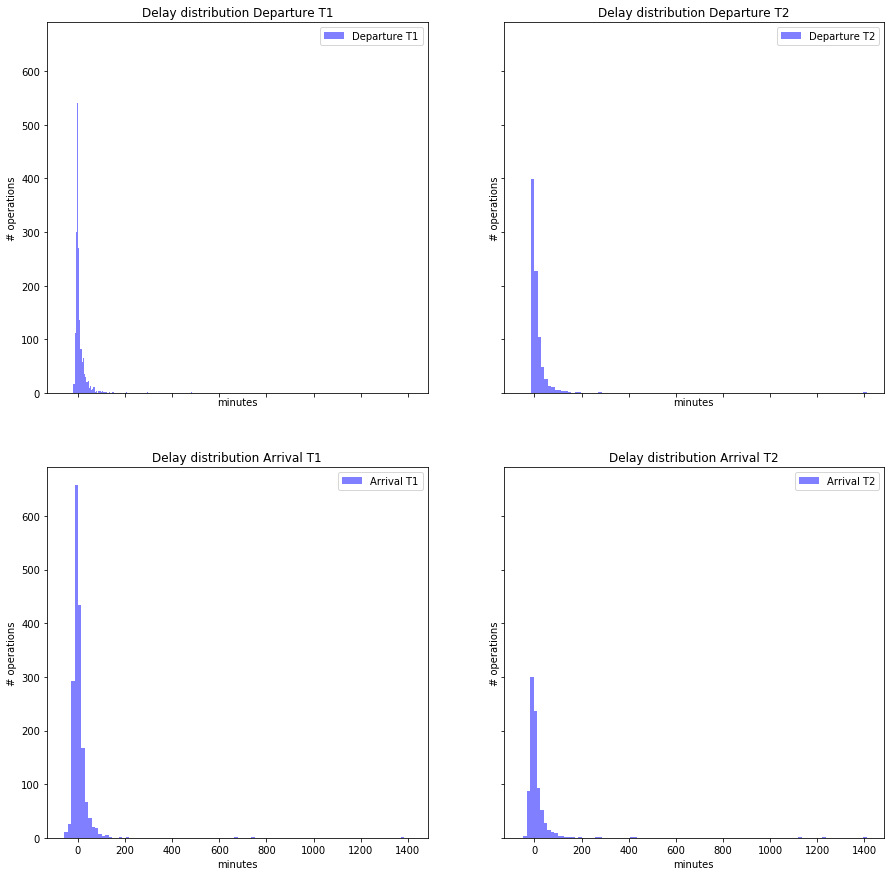

In [106]:
# Anàlisi de la normalitat a nivell visual.
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey = True, sharex = True, figsize=(15,15))
ax1.hist(x = df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') & (df_analisi_2['Terminal']=='1')], bins=100, facecolor='blue', alpha=0.5)
label1 = ['Departure T1']
ax1.legend(label1)
ax1.set(title='Delay distribution Departure T1', ylabel='# operations', xlabel='minutes')
ax2.hist(x = df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') & (df_analisi_2['Terminal']=='2')], bins=100, facecolor='blue', alpha=0.5)
label2 = ['Departure T2']
ax2.legend(label2)
ax2.set(title='Delay distribution Departure T2', ylabel='# operations', xlabel='minutes')
ax3.hist(x = df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') & (df_analisi_2['Terminal']=='1')], bins=100, facecolor='blue', alpha=0.5)
label3 = ['Arrival T1']
ax3.legend(label3)
ax3.set(title='Delay distribution Arrival T1', ylabel='# operations', xlabel='minutes')
ax4.hist(x = df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') & (df_analisi_2['Terminal']=='2')], bins=100, facecolor='blue', alpha=0.5)
label4 = ['Arrival T2']
ax4.legend(label4)
ax4.set(title='Delay distribution Arrival T2', ylabel='# operations', xlabel='minutes')

plt.show()

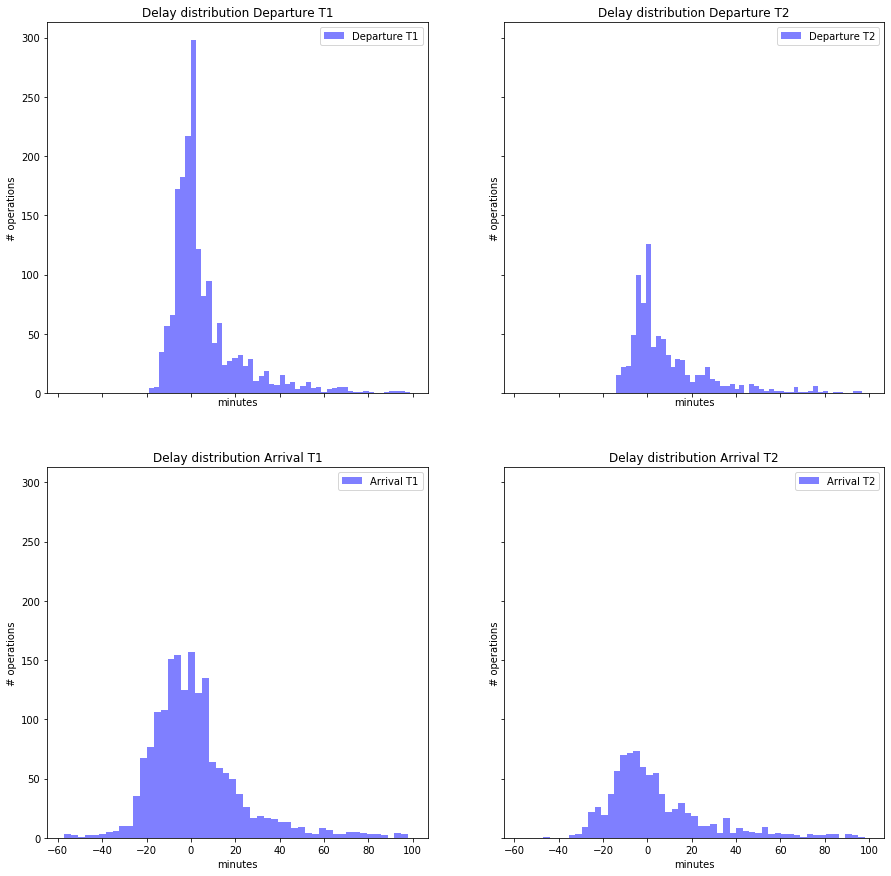

In [107]:
# Anàlisi de la normalitat a nivell visual sense valors superiors a 100minuts
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharey = True, sharex = True, figsize=(15,15))
ax1.hist(x = df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<100)], bins=50, facecolor='blue', alpha=0.5)
label1 = ['Departure T1']
ax1.legend(label1)
ax1.set(title='Delay distribution Departure T1', ylabel='# operations', xlabel='minutes')
ax2.hist(x = df_analisi_2['Delay'][(df_analisi_2['Operation']=='Departure') & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<100)], bins=50, facecolor='blue', alpha=0.5)
label2 = ['Departure T2']
ax2.legend(label2)
ax2.set(title='Delay distribution Departure T2', ylabel='# operations', xlabel='minutes')
ax3.hist(x = df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') & (df_analisi_2['Terminal']=='1') & (df_analisi_2['Delay']<100)], bins=50, facecolor='blue', alpha=0.5)
label3 = ['Arrival T1']
ax3.legend(label3)
ax3.set(title='Delay distribution Arrival T1', ylabel='# operations', xlabel='minutes')
ax4.hist(x = df_analisi_2['Delay'][(df_analisi_2['Operation']=='Arrival') & (df_analisi_2['Terminal']=='2') & (df_analisi_2['Delay']<100)], bins=50, facecolor='blue', alpha=0.5)
label4 = ['Arrival T2']
ax4.legend(label4)
ax4.set(title='Delay distribution Arrival T2', ylabel='# operations', xlabel='minutes')

plt.show()

Text(0.5, 1.0, 'Total operacions al llarg d`una setmana')

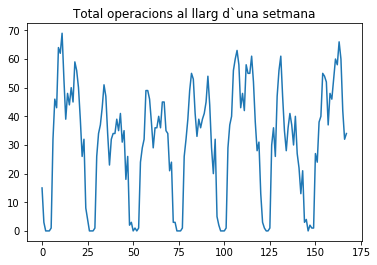

In [108]:
# Representació del número d'operacions al llarg de la setmana.
plt.plot(df_analisi_1_gb_['Time'], df_analisi_1_gb_['Total op'])
plt.title('Total operacions al llarg d`una setmana')

Text(0.5, 1.0, 'Cicle diari d`operacions')

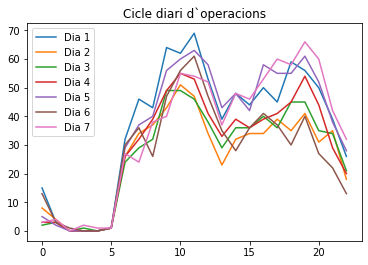

In [109]:
# Superposició de les operacions diàries setmanals
dia = []
for i in range(0,7):
    a = i*24
    plt.plot(np.arange(0,23,1), df_analisi_1_gb_[0+a:23+a]['Total op'])
    dia.append("Dia" + ' '+ str(i+1))
plt.legend(dia)
plt.title('Cicle diari d`operacions')

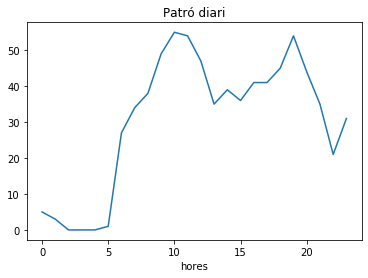

In [110]:
# Càlcul del patró.
matriu_dies = np.zeros((7,24))
for i in range(0,7):
    for j in range(0,24):
        a=i*24
        matriu_dies[i,j] = df_analisi_1_gb_['Total op'][j+a]
# Creem una llista buida on guardar els valors del patró
patro = []
# Calculem la mediana per mes.
for i in range(0,24):
    patro.append(np.median(matriu_dies[:,i]))

# Grafiquem el resultat, que és el nostre patró d'estacionalitat tenint en compte la resta de valors de la dècada.
plt.plot(patro)
plt.title('Patró diari')
plt.xlabel('hores')
plt.show()

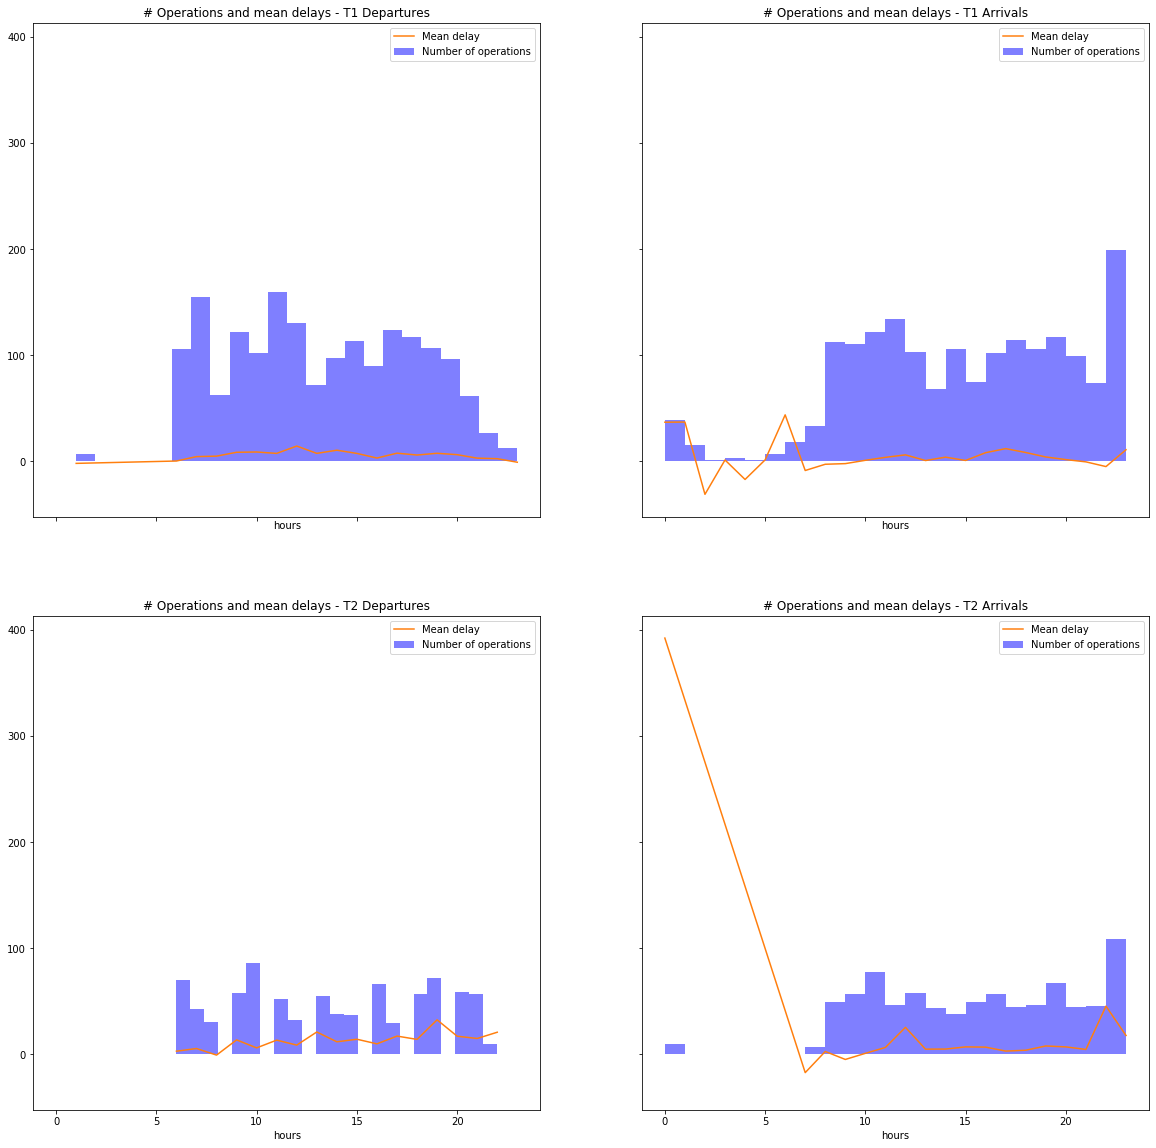

In [112]:
# Visualització delay i total operacions per bloc horari segons operació i terminal.

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, sharey = True, sharex = True, figsize=(20,20))

ax1.hist(x = df_analisi_2['Time block'][(df_analisi_2['Operation']=='Departure') & (df_analisi_2['Terminal']=='1')], bins=23, facecolor='blue', alpha=0.5)
ax1.plot(df_analisi_2_gb['Time block'][(df_analisi_2_gb['Operation']=='Departure') & (df_analisi_2_gb['Terminal']=='1')], df_analisi_2_gb['Mean'][(df_analisi_2_gb['Operation']=='Departure') & (df_analisi_2_gb['Terminal']=='1')])
ax1.set(title='# Operations and mean delays - T1 Departures', xlabel='hours')
label = ('Mean delay', 'Number of operations')
ax1.legend(label)

ax2.hist(x = df_analisi_2['Time block'][(df_analisi_2['Operation']=='Arrival') & (df_analisi_2['Terminal']=='1')], bins=23, facecolor='blue', alpha=0.5)
ax2.plot(df_analisi_2_gb['Time block'][(df_analisi_2_gb['Operation']=='Arrival') & (df_analisi_2_gb['Terminal']=='1')], df_analisi_2_gb['Mean'][(df_analisi_2_gb['Operation']=='Arrival') & (df_analisi_2_gb['Terminal']=='1')])
ax2.set(title='# Operations and mean delays - T1 Arrivals', xlabel='hours')
ax2.legend(label)

ax3.hist(x = df_analisi_2['Time block'][(df_analisi_2['Operation']=='Departure') & (df_analisi_2['Terminal']=='2')], bins=23, facecolor='blue', alpha=0.5)
ax3.plot(df_analisi_2_gb['Time block'][(df_analisi_2_gb['Operation']=='Departure') & (df_analisi_2_gb['Terminal']=='2')], df_analisi_2_gb['Mean'][(df_analisi_2_gb['Operation']=='Departure') & (df_analisi_2_gb['Terminal']=='2')])
ax3.set(title='# Operations and mean delays - T2 Departures', xlabel='hours')
ax3.legend(label)

ax4.hist(x = df_analisi_2['Time block'][(df_analisi_2['Operation']=='Arrival') & (df_analisi_2['Terminal']=='2')], bins=23, facecolor='blue', alpha=0.5)
ax4.plot(df_analisi_2_gb['Time block'][(df_analisi_2_gb['Operation']=='Arrival') & (df_analisi_2_gb['Terminal']=='2')], df_analisi_2_gb['Mean'][(df_analisi_2_gb['Operation']=='Arrival') & (df_analisi_2_gb['Terminal']=='2')])
ax4.set(title='# Operations and mean delays - T2 Arrivals', xlabel='hours')
ax4.legend(label)

plt.show()

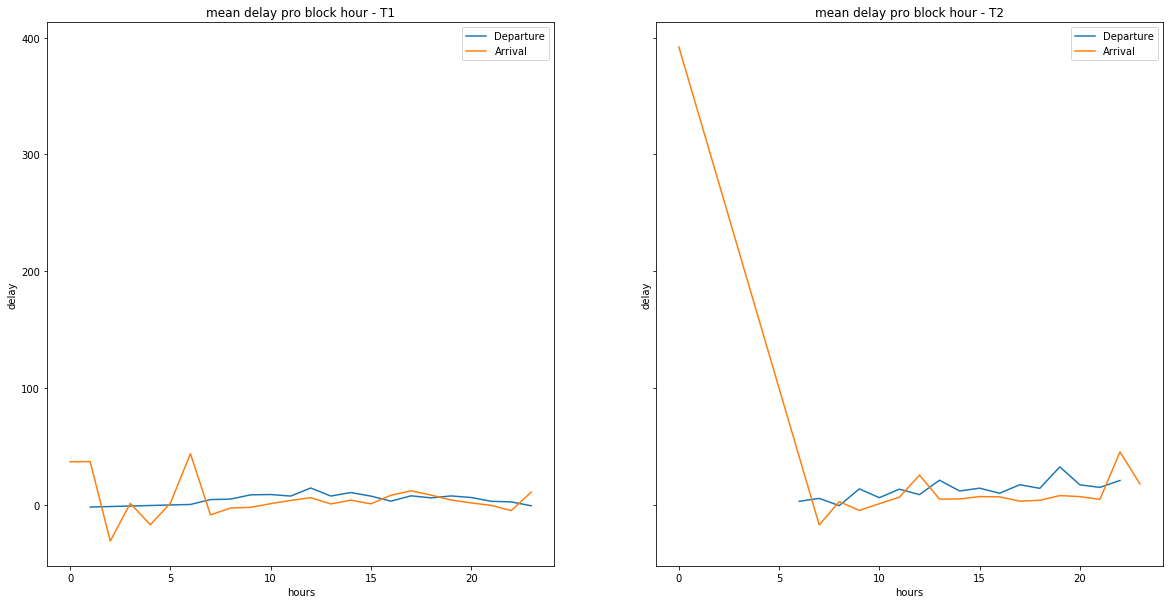

In [115]:
# Visualització delay per bloc horari segons operació i terminal.

fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, sharex = True, figsize=(20,10))

ax1.plot(df_analisi_2_gb['Time block'][(df_analisi_2_gb['Operation']=='Departure') & (df_analisi_2_gb['Terminal']=='1')], df_analisi_2_gb['Mean'][(df_analisi_2_gb['Operation']=='Departure') & (df_analisi_2_gb['Terminal']=='1')])
ax1.plot(df_analisi_2_gb['Time block'][(df_analisi_2_gb['Operation']=='Arrival') & (df_analisi_2_gb['Terminal']=='1')], df_analisi_2_gb['Mean'][(df_analisi_2_gb['Operation']=='Arrival') & (df_analisi_2_gb['Terminal']=='1')])
ax1.set(title='mean delay pro block hour - T1', ylabel='delay', xlabel='hours')
label = ('Departure', 'Arrival')
ax1.legend(label)

ax2.plot(df_analisi_2_gb['Time block'][(df_analisi_2_gb['Operation']=='Departure') & (df_analisi_2_gb['Terminal']=='2')], df_analisi_2_gb['Mean'][(df_analisi_2_gb['Operation']=='Departure') & (df_analisi_2_gb['Terminal']=='2')])
ax2.plot(df_analisi_2_gb['Time block'][(df_analisi_2_gb['Operation']=='Arrival') & (df_analisi_2_gb['Terminal']=='2')], df_analisi_2_gb['Mean'][(df_analisi_2_gb['Operation']=='Arrival') & (df_analisi_2_gb['Terminal']=='2')])
ax2.set(title='mean delay pro block hour - T2', ylabel='delay', xlabel='hours')
ax2.legend(label)

plt.show()